In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

# CHIME ringmaps on cedar

At this point I'm presuming you've managed to get an account setup on cedar, install a CHIME software environment and connect to a Jupyter session running on a compute node. Congratulations, that's often a total pain in the ass to get going, but you're through it all now 🥳

In this tutorial we're going to go over finding and loading ringmaps, and some basic ephemeris calculations.

## Daily Data and CSDs

The fundamental unit processed by the CHIME pipeline is a single [sidereal day](https://en.wikipedia.org/wiki/Sidereal_time), which is the timescale on which the Earth makes a full revolution with respect to the background starts (and not the sun), and is the time with which our measurements repeat. Unfortunately there is no standard labelling for sidereal days (as there are for calendar days), and so we use CHIME Sidereal Days (CSDs, or occasionally referred to in our code as Local Stellar Days, LSDs), the simply count the number of sidereal days since our first pathfinder telescope started running.

The *daily pipeline* loads the raw data for a single sidereal days and processes it to a common grid in sidereal time. It does some extra calibration and RFI flagging and finally outputs the product that we are interested in, a ringmap for the day. To find these ringmaps you'll want to figure out what the latest revision of the daily processing is and look here:

In [2]:
from pathlib import Path

revision = "rev_03"

daily_processing_path = Path(f"/project/rpp-chime/chime/chime_processed/daily/{revision}/")

Within that directory you'll see there are a bunch of subdirectories:

In [3]:
sorted(list(daily_processing_path.iterdir()))[:10]

[PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1797'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1804'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1805'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1806'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1809'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1810'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1811'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1812'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1813')]

Where the number (e.g. `1797`) gives the CSD of the data within it.

Let's see what's inside...

In [4]:
sorted(list((daily_processing_path / "1808").iterdir()))

[PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/delayspectrum_lsd_1808.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/job'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/rfi_mask_lsd_1808.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/ringmap_intercyl_lsd_1808.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/ringmap_lsd_1808.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/sensitivity_lsd_1808.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/sourceflux_OVRO.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/sourceflux_QSO.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/sourceflux_bright.h5'),
 PosixPath('/project/rpp-chime/chime/chime_processed/daily/rev_03/1808/sstream_lsd_1808.h5')]

You can see a whole bunch of files in there, the ones of most interest to us are the `ringmap*.h5` ones, but for completeness the others are:

- `delayspectrum`: an estimate of the power spectrum in the frequency axis. Useful to assessing data quality.
- `rfi_mask`: the RFI mask derived. Gives an indication of how bad the day was in terms of RFI, but it will have already been applied.
- `sensitivity`: estimates of the sensitvity of the data from both the high cadence weight estimates and derived from the autocorrelations assuming radiometric noise.
- `sourceflux`: direct measurements of the source fluxes of sources into various catalogs.
- `stream`: the cleaned, calibrated visibility data gridded into the sidereal day.

Let's load up a ringmap. Note, they're pretty large (~200 GB), so it's not practical to load them entirely into memory in a single node Jupyter session, to that end we're going to downselect the frequencies and polarisations that we load:

In [5]:
from draco.core import containers

fsel = slice(0, 32)  # Load only the first 32 frequencies (given as a slice)
psel = [0, 3]  # Load only the first and fourth polarisations (XX and YY)

ringmap = containers.RingMap.from_file(
    daily_processing_path / "1808" / "ringmap_lsd_1808.h5", freq_sel=fsel, pol_sel=psel
)

Easy. Now let's try and plot some maps.

Text(0, 0.5, 'sin(ZA)')

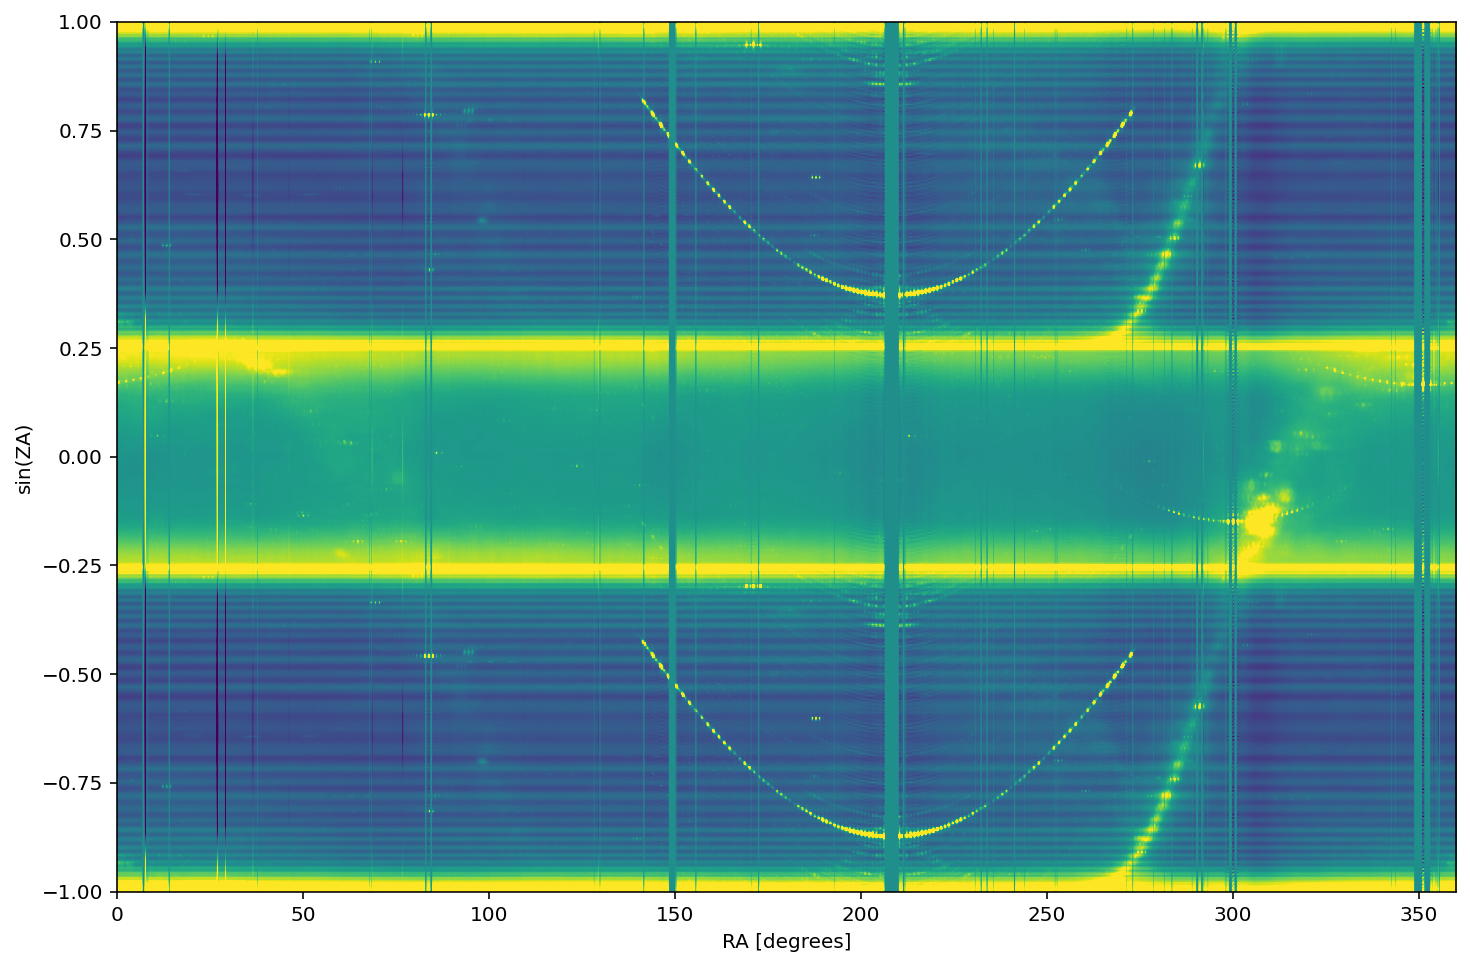

In [6]:
fig, axis = plt.subplots(1, 1, figsize=(12, 8))

axis.imshow(ringmap.map[0, 0, 28].T, vmin=-20, vmax=20, aspect="auto", origin="lower", extent=(0, 360, -1, 1))

axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

It's starting to look okay, but you might wonder what is all the weird striping going on?? That comes from the interactions between the closely packed feeds on the CHIME focal line, that have amplifier noise broadcast from one feed and received by neighbouring ones. Fortunately it's mostly fairly time stable, so we fairly simply remove it with a time average.

First let's pick a quiet region of sky (rom 100 to 130 degrees looks pretty good to me), then we're going to calculate the RA average within that window.

In [7]:
# First get the indices corresponding to the start and end region
start_ind, end_ind = np.searchsorted(ringmap.ra, (100, 130))

def destripe(m, start, end):
    """Subtract the median of a map with a region from start:end"""
    
    med = np.median(m[:, start:end], axis=1)
    return m - med[:, np.newaxis]


map_destriped = destripe(ringmap.map[0, 0, 28].T, start_ind, end_ind)

Text(0, 0.5, 'sin(ZA)')

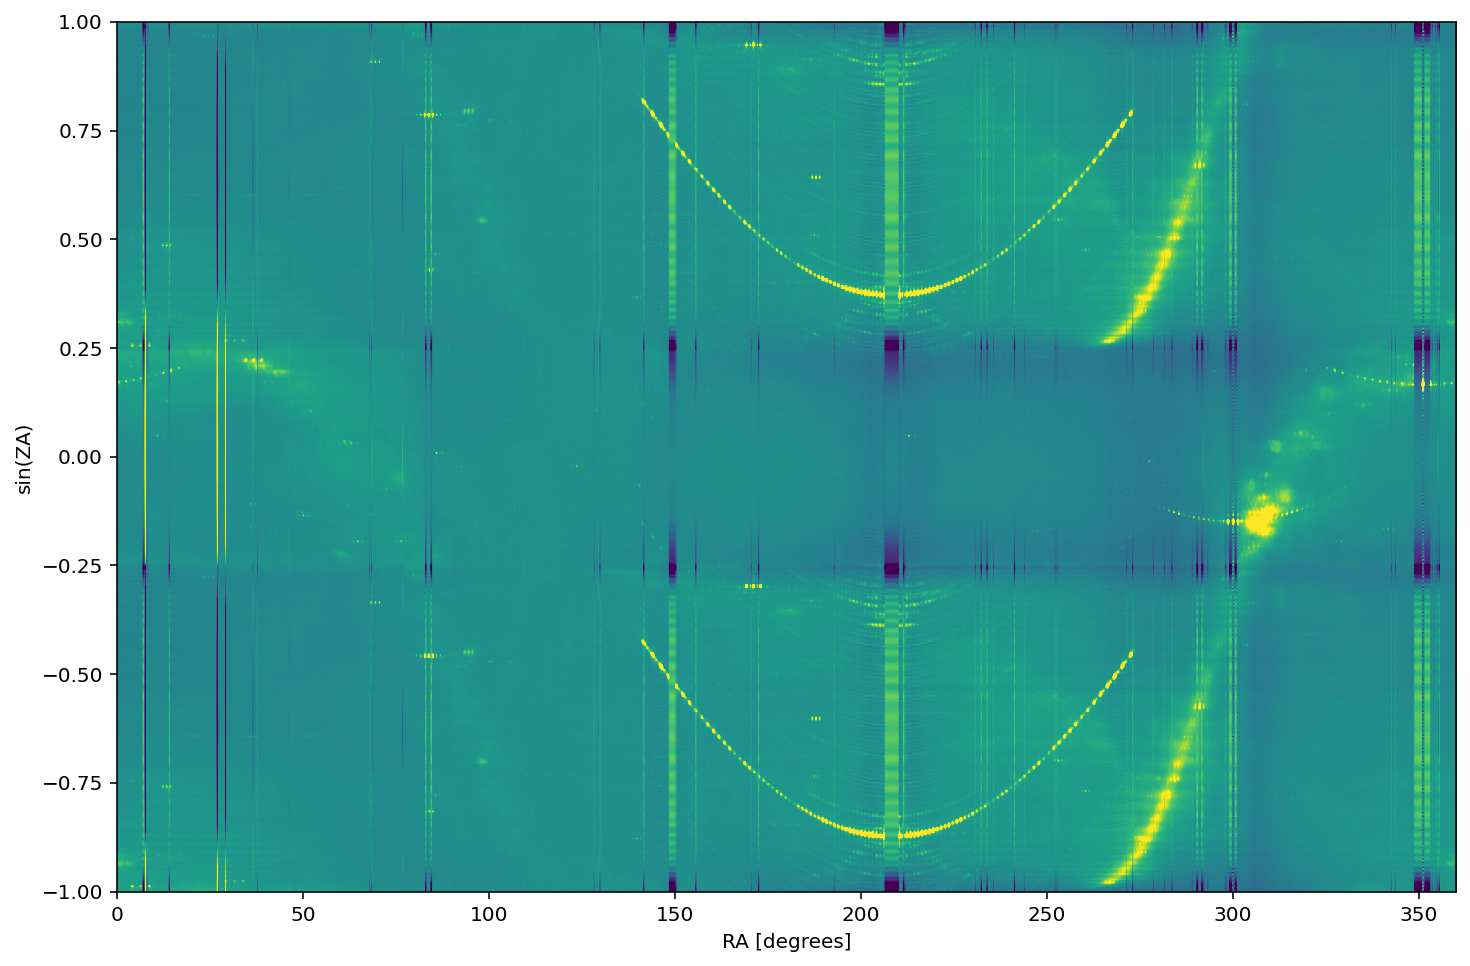

In [8]:
fig, axis = plt.subplots(1, 1, figsize=(12, 8))

axis.imshow(map_destriped, vmin=-20, vmax=20, aspect="auto", origin="lower", extent=(0, 360, -1, 1))

axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

 Okay, that's looking better, but there's still a bunch of weird artifacts. Let's start with the thin vertical lines containing the same horizontal striping pattern. If you look in the map above you can see that they actually were zero in the map above, and what's happened is they have taken on the negative of the striping pattern we subtracted out. The reason they were zero is that they had been masked out as bad data, we can see that by the `weight` or the `rms` dataset. Note that some older files will *only* have the `rms` dataset. Masked data corresponds to `rms = 0` values.
 
Let's replot the map above, but explicitly marking the data as missing...

In [9]:
map_destriped_nan = np.where((ringmap.rms[0, 28] == 0)[np.newaxis, :], np.nan, map_destriped)

Text(0, 0.5, 'sin(ZA)')

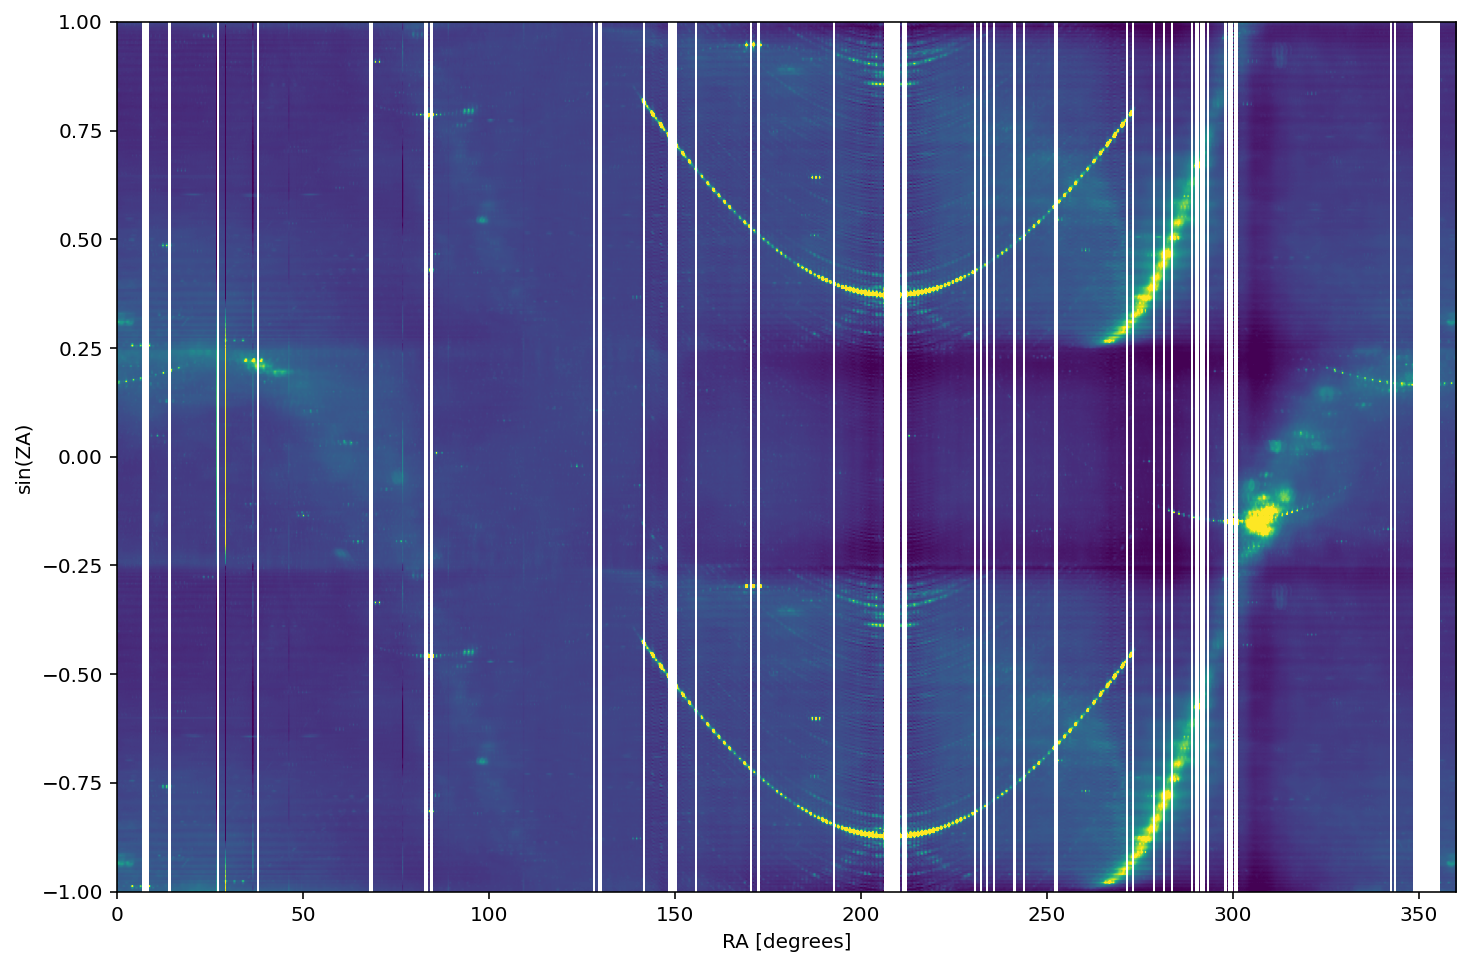

In [10]:
fig, axis = plt.subplots(1, 1, figsize=(12, 8))

axis.imshow(map_destriped_nan, vmin=-5, vmax=20, aspect="auto", origin="lower", extent=(0, 360, -1, 1))

axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

Much better. The only thing that is left is those giant horseshoes in the middle. That artifact is the sun! Most things on the sky CHIME only really sees when they are directly overhead, but the sun is sufficiently bright we see it through the whole day time. The horseshoes appear because the sun the sun is the furthest south when it transits through the meridian, and so as we move away from transit (either before or after) the sub appears further and further north even though it is only being seen through a side lobe in the east west direction.

To get rid of the effects of the sun, we need to be able to calculate when day time is, and so we can excise the whole region. To do that we need to understand how to convert CSDs to times (and vice-versa) and how to calculate the positions of objects on the sky. To do that we are going to need to use some *ephemeris* routines.

NOTE: times labelling CHIME data are always [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) stored as a double precision floating point number of seconds since the UNIX epoch (i.e. a [UNIX time](https://en.wikipedia.org/wiki/Unix_time)).

First let's figure out what actual calendar day we are dealing with, i.e what time corresponds to CSD=1808.

In [11]:
from ch_util import ephemeris

t1808 = ephemeris.csd_to_unix(1808)
t1808

1540273981.8457599

Which might be easier to understand as a datetime object...

In [12]:
ephemeris.unix_to_datetime(t1808)

datetime.datetime(2018, 10, 23, 5, 53, 1, 845760, tzinfo=datetime.timezone.utc)

Yikes, that's way back in 2018! We've been working on this a long time now.

Alright. Let's get serious and figure out when sun-rise, set and solar noon (i.e sun transit) actually are. Fortunately `ch_util.ephemeris` has routines to make this calculation easy.

In [13]:
solar_transit = ephemeris.solar_transit(t1808)  # Get the next solar transit time after the specified time
sun_rise = ephemeris.solar_rising(t1808)  # Get the next sun rise after the given time
sun_set = ephemeris.solar_setting(t1808)  # ... same for sun set

This has given the UTC times of these events, but to put them on the plot above we'll need to convert them to the right-ascension at transit. There are a few ways to do this: we could first convert them to a CSD (`ephemeris.unix_to_csd`) and then use the fact that each sidereal day starts with RA=0 degrees transiting and ends with RA=360 degrees transiting.

In [14]:
(ephemeris.unix_to_csd(solar_transit) % 1.0) * 360.0

array([208.01034842])

... or we can use the routine `ephemeris.lsa` (Local Stellar Angle, i.e. the RA at transit), which does all of this for us.

In [15]:
ephemeris.lsa(solar_transit)

array([208.01034842])

Let's put all of those on a plot...

Text(0, 0.5, 'sin(ZA)')

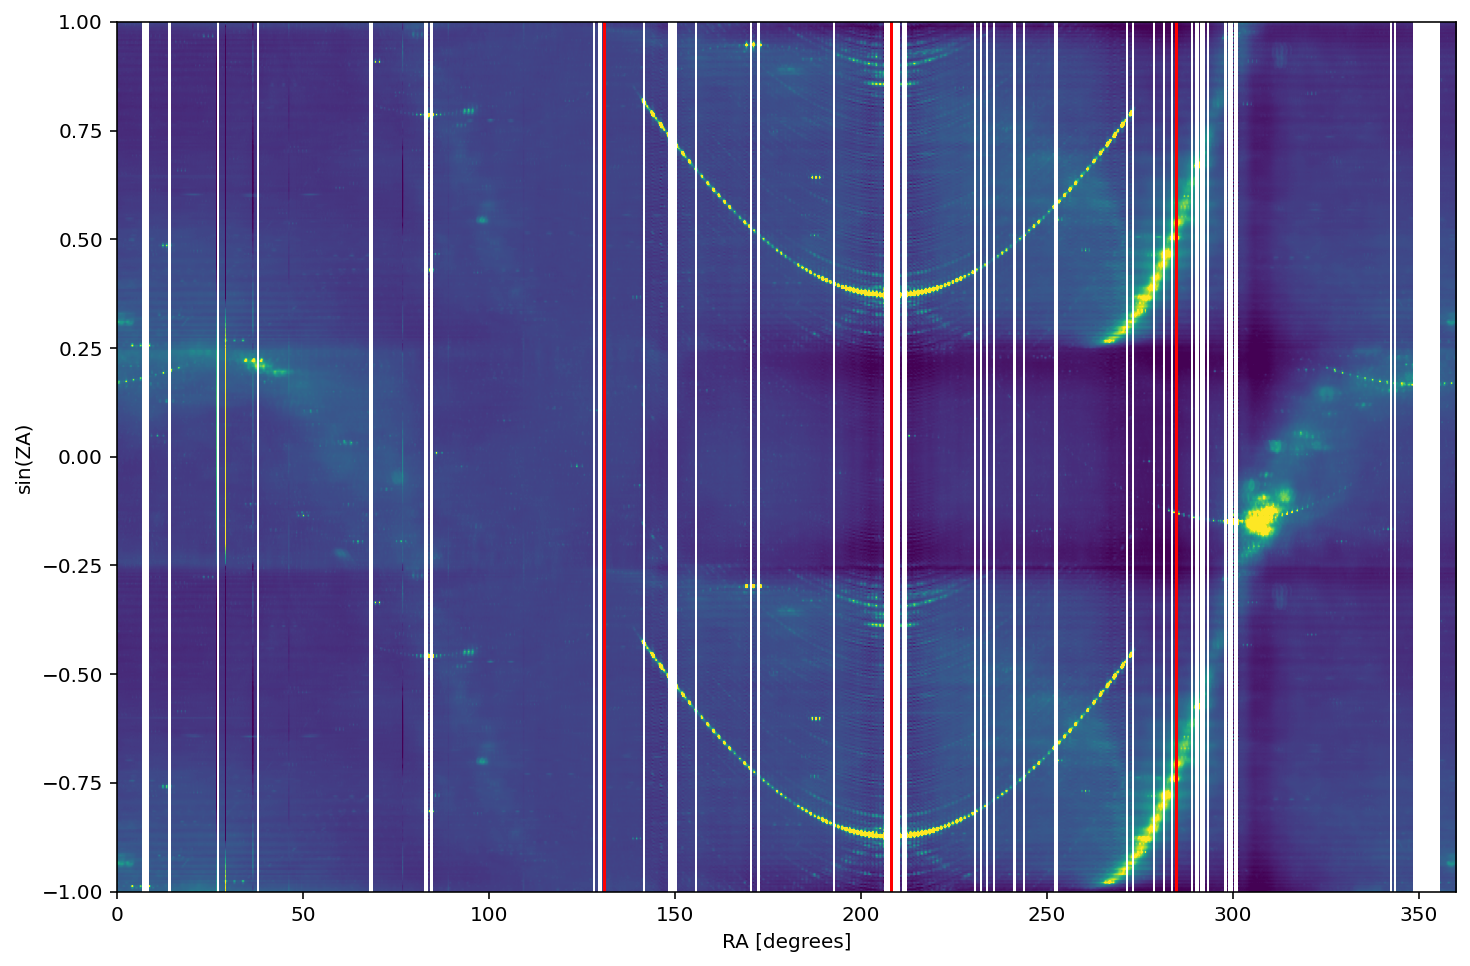

In [16]:
fig, axis = plt.subplots(1, 1, figsize=(12, 8))

axis.imshow(map_destriped_nan, vmin=-5, vmax=20, aspect="auto", origin="lower", extent=(0, 360, -1, 1))

for t in [sun_rise, solar_transit, sun_set]:
    axis.axvline(ephemeris.lsa(t), color="r")

axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

As you can see, that marks out where the sun would have transited (although it's in a region which is masked out), and the times of sun rise and sun set. You'll notice that actually the horseshoe trails of the sun stop a little before that, that can happen at certain times of year when the sun rises/sets behind one of the local mountains and so the local horizon is actually higher than the true horizon.

And so that concludes this tutorial. There's a whole bunch of other useful routines within `ephemeris` including ones that calculate lunar transit times etc, and more advanced routines that can calculate full positions of objects.

Also, there are ringmaps generated from the averages of many days located here: `/project/rpp-chime/chime/chime_processed/stacks/rev_03/all/ringmap.h5`